In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
from pennylane.optimize import NesterovMomentumOptimizer , GradientDescentOptimizer, AdamOptimizer
#FILE NAMING: VCDR_v7_MD_2Q_ST2_N02_B6L3_BS32_LR02
#             VCDR = Variational Classifier with Data Re-upload
#             MD = Michael's Dataset
#             2Q = 2Qubits
#             ST2 = Surface type 2
#             N02 = noise = 0.2/d
#             B6L3 = 6 Blocks, 2 layers
#             BS32 = Batch size 32
#             LR02 = Learning Rate 0.2
#             optimizer


from numpy import loadtxt
# load array
X_train = loadtxt('X_train_ST2_N05.csv', delimiter=',')
y_train = loadtxt('y_train_ST2_N05.csv', delimiter=',')
X_val = loadtxt('X_val_ST2_N05.csv', delimiter=',')
y_val = loadtxt('y_val_ST2_N05.csv', delimiter=',')
X_test = loadtxt('X_test_ST2_N05.csv', delimiter=',')
y_test = loadtxt('y_test_ST2_N05.csv', delimiter=',')

#entangler = qml.CZ
n_qubits = 2
entangler = qml.CNOT
blocks=3
layers=1
batch_size = 16
n_epochs = 25
test_size=0.2 #(train/test split)
learning_rate = 0.2
learning_rate1 = 0.05
#opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = NesterovMomentumOptimizer(learning_rate)
#opt = GradientDescentOptimizer(stepsize=learning_rate)
randomseed=1 # Change random seed in weight
#scalinga=-np.pi #Normalizing dataset from
#scalingb=np.pi #Normalizing dataset to
opt = AdamOptimizer(learning_rate)
opt1 = AdamOptimizer(learning_rate1)

scalinga = 0
scalingb = 2*np.pi
#Simulations
# surface type 0,1,2
# noise= 0.0 , 0.4 , 0.6 , 0.8 , 1.0 , 1.2 
# blocks 3-6-9-12
# layers 1-2-3-5
# optimizer
# batch_size: 32-40-64
# epochs = 25

# use same datasets, so save them 
#A For a surface type=0,1,2 , noise=0 and blocks=1 : Find best layers , optimizers , epochs , batchsize
#B For a surface type=0,1,2 , noise=0 and blocks=3,6,9,12 : Find best layers , optimizers , epochs , batchsize


# Things to try in extreme regimes (zero and max noise) and benchmark with best results:
#1. best simulations benchmark with CZ gates instead of CNOT -> 
#(passing the imprimitive=qml.CZ keyword argument to StronglyEntanglingLayers)

#2. omit the entanglers for the last layer.

#3. cost function studied in the paper (that is also showcased in the Data-reuploading classifier demonstration)
#was related to the fidelity of the final state of the circuit.

#4. Noisy channels https://pennylane.readthedocs.io/en/stable/introduction/operations.html#intro-ref-ops-channels

#5. Use measurement in both qubits and then softmax outcome

#5. Use probability measurement https://pennylane.readthedocs.io/en/stable/introduction/measurements.html

#6. add hadamard gates qml.Hadamard(wires=wires[0])

#7. Try different rotations RX RY in the angle embedding

#In the basic variational classifier 
#1. We measure the outcome of the 1 qubit. Does it make sense to build a procedure that measures 2 qubits? 
#2. How about probability measurement instead of expectation value?
#3. Does it make sense to add Hadamard gates before?
#4. Are there any differences using CNOT and CZ in the strongly entangling layers?
from itertools import chain
%matplotlib inline
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
from pennylane.optimize import GradientDescentOptimizer
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_file, output_notebook, reset_output, ColumnDataSource
import matplotlib.pyplot as plt
from itertools import chain

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
from pennylane.optimize import GradientDescentOptimizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler

#Xnorm = minmax_scale(X, feature_range=(0, np.pi))
#X_train_val, X_test, y_train_val, y_test = train_test_split(Xnorm, y, test_size=0.5)
y_train = pd.DataFrame(y_train)
y_train = y_train[0].apply(lambda x: 1 if x <= 0 else -1)
y_train = y_train.to_numpy()
y_test = pd.DataFrame(y_test)
y_test = y_test[0].apply(lambda x: 1 if x <= 0 else -1)
y_test = y_test.to_numpy()
y_val = pd.DataFrame(y_val)
y_val = y_val[0].apply(lambda x: 1 if x <= 0 else -1)
y_val = y_val.to_numpy()
#y_ = y.iloc[:, :]
#y = y[0].apply(lambda x: 1 if x <= 0 else -1)
#y = y.to_numpy()
X_train= minmax_scale(X_train, feature_range=(scalinga, scalingb))
X_val= minmax_scale(X_val, feature_range=(scalinga, scalingb))
X_test= minmax_scale(X_test, feature_range=(scalinga, scalingb))
Xnorm=X_train

#split into train and test set
#X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=test_size, random_state=1)
 

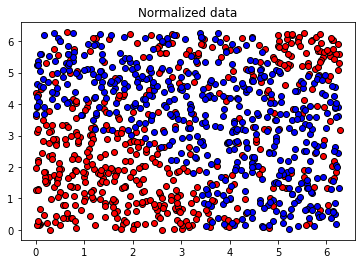

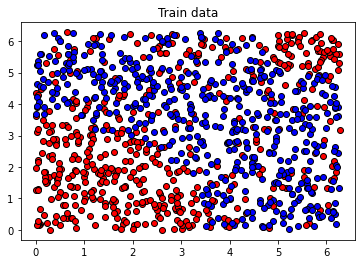

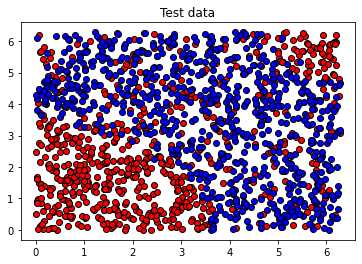

In [3]:
import matplotlib.pyplot as plt
Xnorm = X_train
y = y_train

plt.figure()
plt.scatter(Xnorm[:, 0][y == -1], Xnorm[:, 1][y == -1], c="r", marker="o", edgecolors="k")
plt.scatter(Xnorm[:, 0][y == 1], Xnorm[:, 1][y == 1], c="b", marker="o", edgecolors="k")
plt.title("Normalized data")
plt.show()


plt.figure()
plt.scatter(X_train[:, 0][y_train == -1], X_train[:, 1][y_train == -1], c="r", marker="o", edgecolors="k")
plt.scatter(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], c="b", marker="o", edgecolors="k")
plt.title("Train data")
plt.show()


plt.figure()
plt.scatter(X_test[:, 0][y_test == -1], X_test[:, 1][y_test == -1], c="r", marker="o", edgecolors="k")
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], c="b", marker="o", edgecolors="k")
plt.title("Test data")
plt.show()

<Figure size 432x288 with 0 Axes>

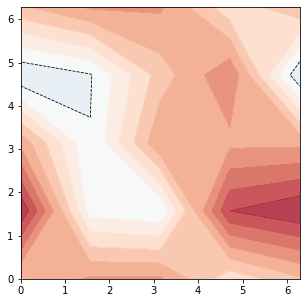

It 1 out of 1550 loss:  0.6213654506813273  : Acc train:  0.51  : Acc test :  0.483  : Auc :  0.495


<Figure size 432x288 with 0 Axes>

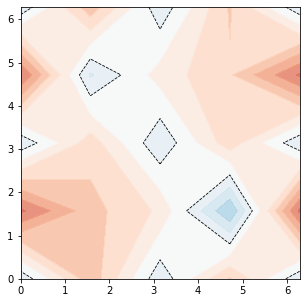

It 11 out of 1550 loss:  0.8557096346908483  : Acc train:  0.58  : Acc test :  0.549  : Auc :  0.557


<Figure size 432x288 with 0 Axes>

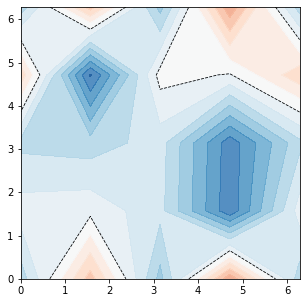

It 21 out of 1550 loss:  1.0319623989576856  : Acc train:  0.55  : Acc test :  0.547  : Auc :  0.539


<Figure size 432x288 with 0 Axes>

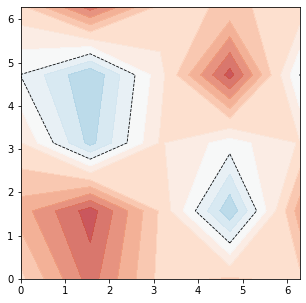

It 31 out of 1550 loss:  1.2517972359607865  : Acc train:  0.61  : Acc test :  0.573  : Auc :  0.585


<Figure size 432x288 with 0 Axes>

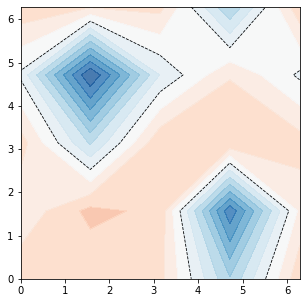

It 41 out of 1550 loss:  0.9569442153054519  : Acc train:  0.57  : Acc test :  0.602  : Auc :  0.604


<Figure size 432x288 with 0 Axes>

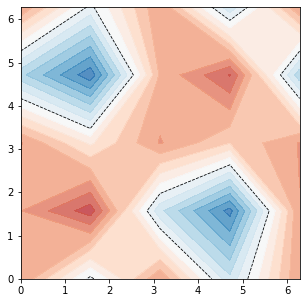

It 51 out of 1550 loss:  1.118179768701675  : Acc train:  0.59  : Acc test :  0.573  : Auc :  0.58


<Figure size 432x288 with 0 Axes>

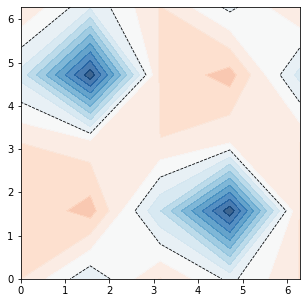

It 61 out of 1550 loss:  0.8959180715989732  : Acc train:  0.63  : Acc test :  0.589  : Auc :  0.59


<Figure size 432x288 with 0 Axes>

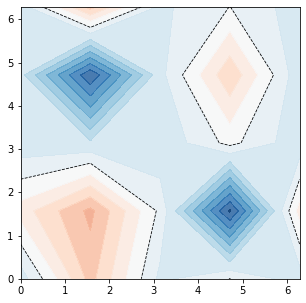

It 71 out of 1550 loss:  0.6746256908681376  : Acc train:  0.6  : Acc test :  0.606  : Auc :  0.603


<Figure size 432x288 with 0 Axes>

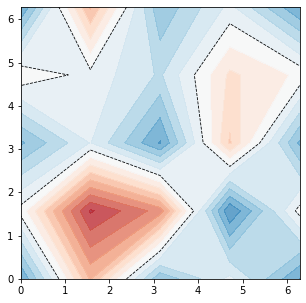

It 81 out of 1550 loss:  0.7831562545399571  : Acc train:  0.61  : Acc test :  0.607  : Auc :  0.604


<Figure size 432x288 with 0 Axes>

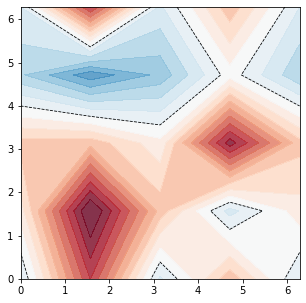

It 91 out of 1550 loss:  0.8349971205996354  : Acc train:  0.65  : Acc test :  0.635  : Auc :  0.641


<Figure size 432x288 with 0 Axes>

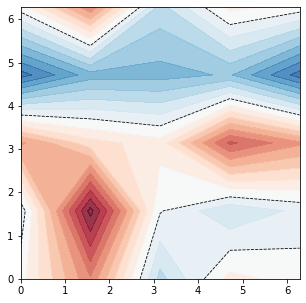

It 101 out of 1550 loss:  1.141155109228441  : Acc train:  0.64  : Acc test :  0.651  : Auc :  0.651


<Figure size 432x288 with 0 Axes>

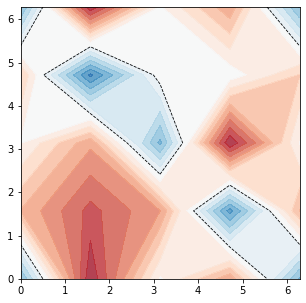

It 111 out of 1550 loss:  0.748347051281915  : Acc train:  0.63  : Acc test :  0.584  : Auc :  0.592


<Figure size 432x288 with 0 Axes>

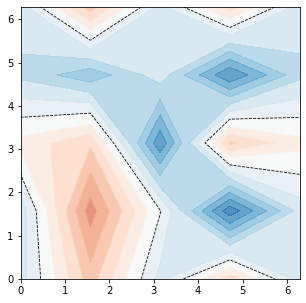

It 121 out of 1550 loss:  0.6646484237292574  : Acc train:  0.68  : Acc test :  0.643  : Auc :  0.64


<Figure size 432x288 with 0 Axes>

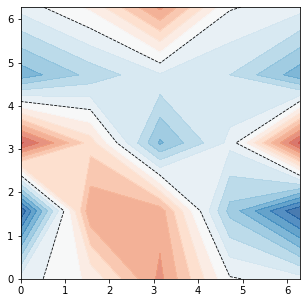

It 131 out of 1550 loss:  0.7030756801696685  : Acc train:  0.64  : Acc test :  0.605  : Auc :  0.605


<Figure size 432x288 with 0 Axes>

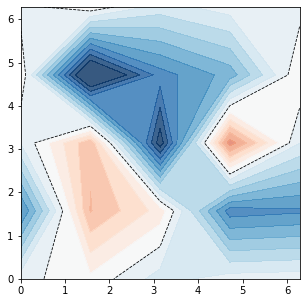

It 141 out of 1550 loss:  1.1282401607655301  : Acc train:  0.65  : Acc test :  0.673  : Auc :  0.667


<Figure size 432x288 with 0 Axes>

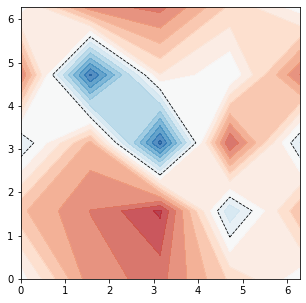

It 151 out of 1550 loss:  0.6184610517275211  : Acc train:  0.65  : Acc test :  0.575  : Auc :  0.586


<Figure size 432x288 with 0 Axes>

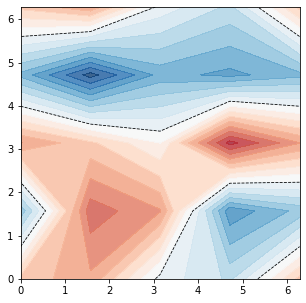

It 161 out of 1550 loss:  1.1506651768816747  : Acc train:  0.66  : Acc test :  0.678  : Auc :  0.679


<Figure size 432x288 with 0 Axes>

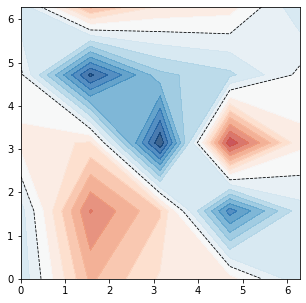

It 171 out of 1550 loss:  0.7418973379406322  : Acc train:  0.7  : Acc test :  0.666  : Auc :  0.666


<Figure size 432x288 with 0 Axes>

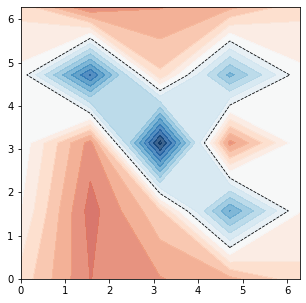

It 181 out of 1550 loss:  0.6487550905505439  : Acc train:  0.68  : Acc test :  0.611  : Auc :  0.618


<Figure size 432x288 with 0 Axes>

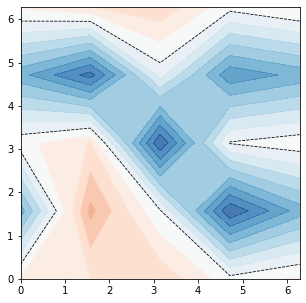

It 191 out of 1550 loss:  1.4594704275249182  : Acc train:  0.69  : Acc test :  0.655  : Auc :  0.652


<Figure size 432x288 with 0 Axes>

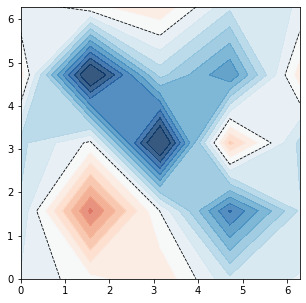

It 201 out of 1550 loss:  0.9149580107679703  : Acc train:  0.67  : Acc test :  0.675  : Auc :  0.667


<Figure size 432x288 with 0 Axes>

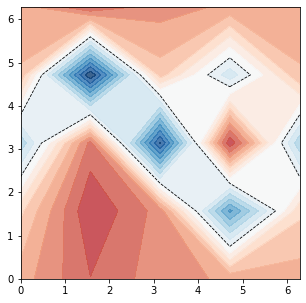

It 211 out of 1550 loss:  1.3251185012148237  : Acc train:  0.65  : Acc test :  0.589  : Auc :  0.599


<Figure size 432x288 with 0 Axes>

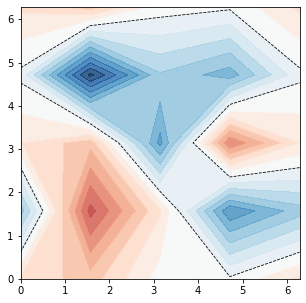

It 221 out of 1550 loss:  0.8216165603286876  : Acc train:  0.68  : Acc test :  0.694  : Auc :  0.692


<Figure size 432x288 with 0 Axes>

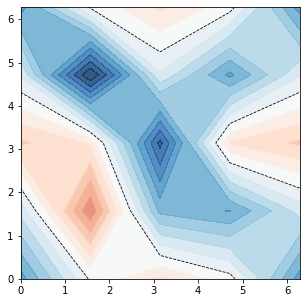

It 231 out of 1550 loss:  0.7248185818389503  : Acc train:  0.67  : Acc test :  0.66  : Auc :  0.653


<Figure size 432x288 with 0 Axes>

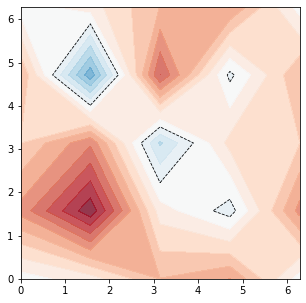

It 241 out of 1550 loss:  0.9681259874554007  : Acc train:  0.6  : Acc test :  0.574  : Auc :  0.587


<Figure size 432x288 with 0 Axes>

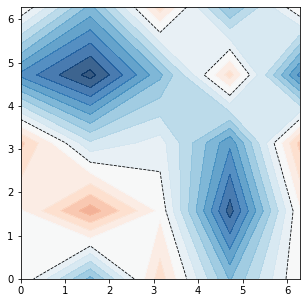

It 251 out of 1550 loss:  0.704056706319369  : Acc train:  0.68  : Acc test :  0.663  : Auc :  0.657


<Figure size 432x288 with 0 Axes>

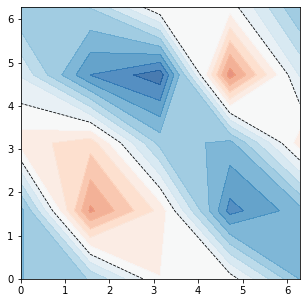

It 261 out of 1550 loss:  1.2126492376703386  : Acc train:  0.64  : Acc test :  0.636  : Auc :  0.632


<Figure size 432x288 with 0 Axes>

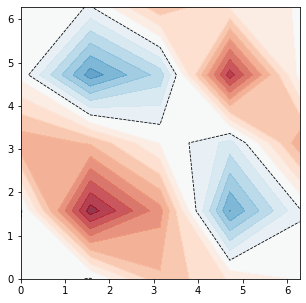

It 271 out of 1550 loss:  0.43453299701712655  : Acc train:  0.68  : Acc test :  0.653  : Auc :  0.658


<Figure size 432x288 with 0 Axes>

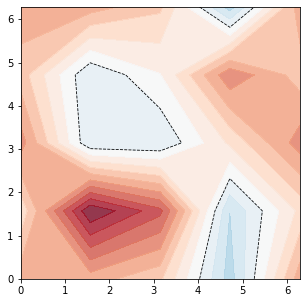

It 281 out of 1550 loss:  0.8831808205376657  : Acc train:  0.62  : Acc test :  0.583  : Auc :  0.592


<Figure size 432x288 with 0 Axes>

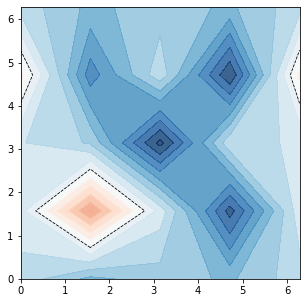

It 291 out of 1550 loss:  0.8329361648068495  : Acc train:  0.61  : Acc test :  0.637  : Auc :  0.624


<Figure size 432x288 with 0 Axes>

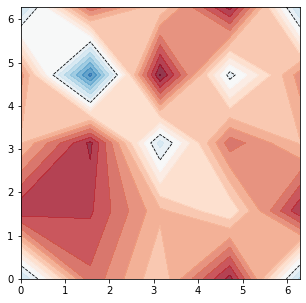

It 301 out of 1550 loss:  1.011736222887781  : Acc train:  0.56  : Acc test :  0.528  : Auc :  0.544


<Figure size 432x288 with 0 Axes>

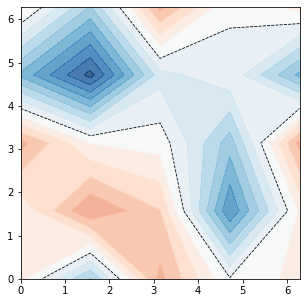

It 311 out of 1550 loss:  0.8143494062354075  : Acc train:  0.69  : Acc test :  0.653  : Auc :  0.653


<Figure size 432x288 with 0 Axes>

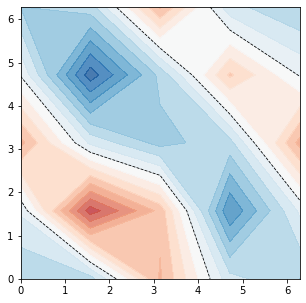

It 321 out of 1550 loss:  0.6482008117820732  : Acc train:  0.64  : Acc test :  0.623  : Auc :  0.621


<Figure size 432x288 with 0 Axes>

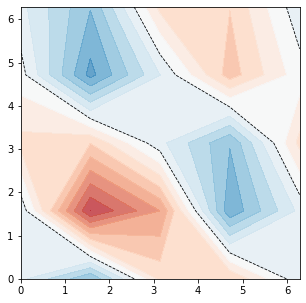

It 331 out of 1550 loss:  0.6675173196914972  : Acc train:  0.68  : Acc test :  0.629  : Auc :  0.631


<Figure size 432x288 with 0 Axes>

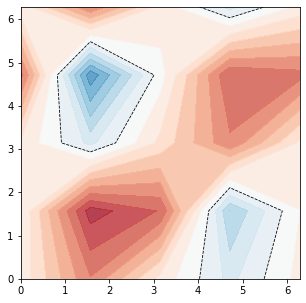

It 341 out of 1550 loss:  1.3398615616926879  : Acc train:  0.6  : Acc test :  0.583  : Auc :  0.593


<Figure size 432x288 with 0 Axes>

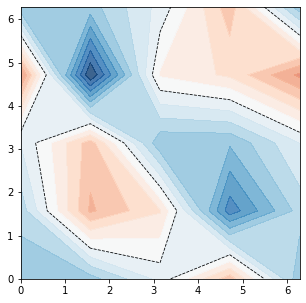

It 351 out of 1550 loss:  0.6990680709738392  : Acc train:  0.63  : Acc test :  0.613  : Auc :  0.611


<Figure size 432x288 with 0 Axes>

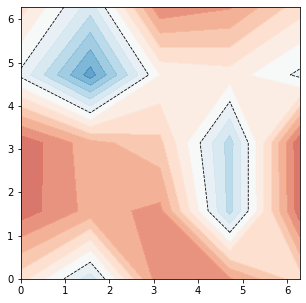

It 361 out of 1550 loss:  1.074917460218097  : Acc train:  0.65  : Acc test :  0.595  : Auc :  0.604


<Figure size 432x288 with 0 Axes>

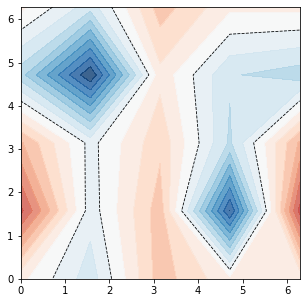

It 371 out of 1550 loss:  0.7446562569957988  : Acc train:  0.66  : Acc test :  0.631  : Auc :  0.631


<Figure size 432x288 with 0 Axes>

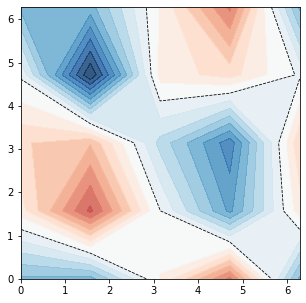

It 381 out of 1550 loss:  0.5654563031378078  : Acc train:  0.69  : Acc test :  0.639  : Auc :  0.64


<Figure size 432x288 with 0 Axes>

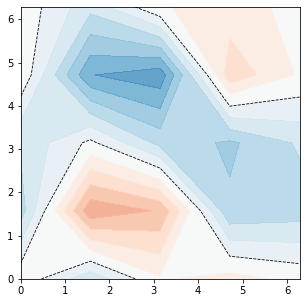

It 391 out of 1550 loss:  0.8362841590113284  : Acc train:  0.64  : Acc test :  0.621  : Auc :  0.62


<Figure size 432x288 with 0 Axes>

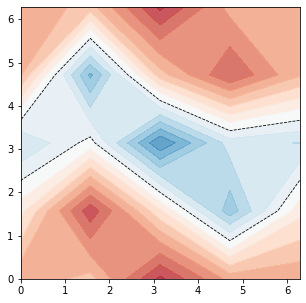

It 401 out of 1550 loss:  0.7735654144560111  : Acc train:  0.66  : Acc test :  0.615  : Auc :  0.622


<Figure size 432x288 with 0 Axes>

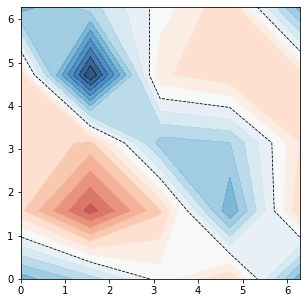

It 411 out of 1550 loss:  0.8677809583483632  : Acc train:  0.68  : Acc test :  0.633  : Auc :  0.635


<Figure size 432x288 with 0 Axes>

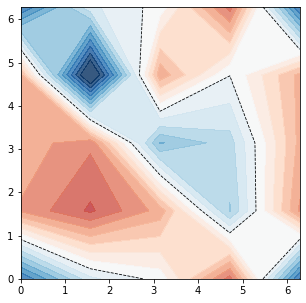

It 421 out of 1550 loss:  0.8693279657889789  : Acc train:  0.67  : Acc test :  0.597  : Auc :  0.603


<Figure size 432x288 with 0 Axes>

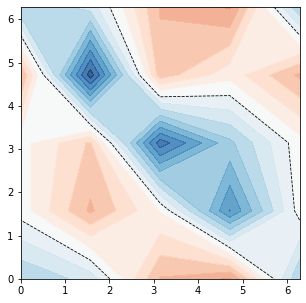

It 431 out of 1550 loss:  0.6964465913306026  : Acc train:  0.69  : Acc test :  0.617  : Auc :  0.621


<Figure size 432x288 with 0 Axes>

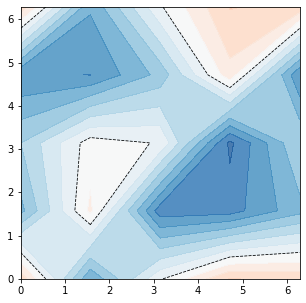

It 441 out of 1550 loss:  0.866108581705521  : Acc train:  0.6  : Acc test :  0.586  : Auc :  0.575


<Figure size 432x288 with 0 Axes>

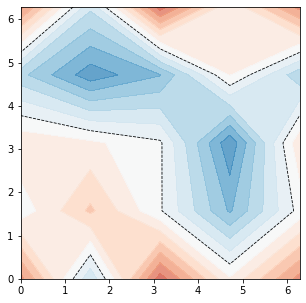

It 451 out of 1550 loss:  0.9338880060956891  : Acc train:  0.74  : Acc test :  0.693  : Auc :  0.693


<Figure size 432x288 with 0 Axes>

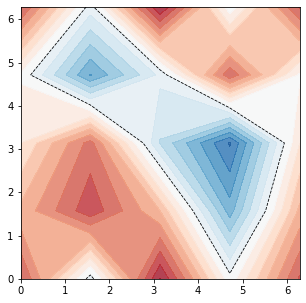

It 461 out of 1550 loss:  0.5609511279122554  : Acc train:  0.72  : Acc test :  0.664  : Auc :  0.67


<Figure size 432x288 with 0 Axes>

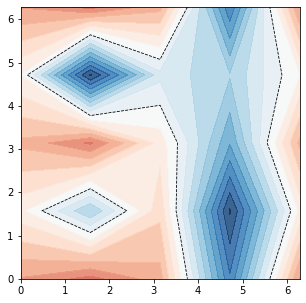

It 471 out of 1550 loss:  1.3585788776551997  : Acc train:  0.66  : Acc test :  0.623  : Auc :  0.623


<Figure size 432x288 with 0 Axes>

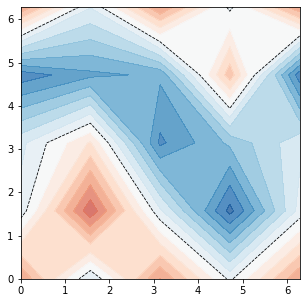

It 481 out of 1550 loss:  0.8019073733407894  : Acc train:  0.75  : Acc test :  0.717  : Auc :  0.715


<Figure size 432x288 with 0 Axes>

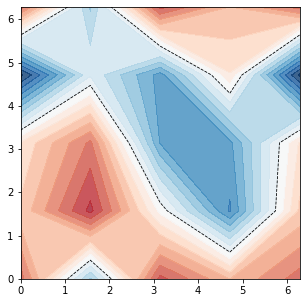

It 491 out of 1550 loss:  0.5953375909488716  : Acc train:  0.73  : Acc test :  0.693  : Auc :  0.693


<Figure size 432x288 with 0 Axes>

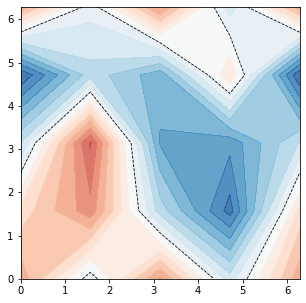

It 501 out of 1550 loss:  1.1605339438954425  : Acc train:  0.74  : Acc test :  0.7  : Auc :  0.698


<Figure size 432x288 with 0 Axes>

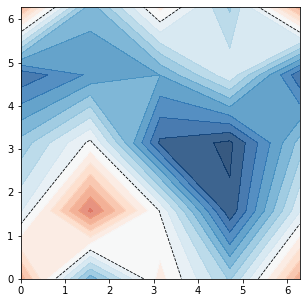

It 511 out of 1550 loss:  0.3570136576796166  : Acc train:  0.71  : Acc test :  0.718  : Auc :  0.71


<Figure size 432x288 with 0 Axes>

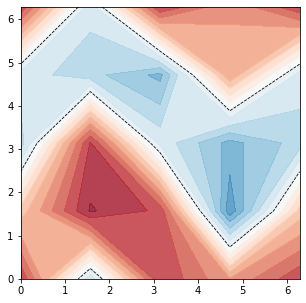

It 521 out of 1550 loss:  0.9364706554167739  : Acc train:  0.71  : Acc test :  0.681  : Auc :  0.684


<Figure size 432x288 with 0 Axes>

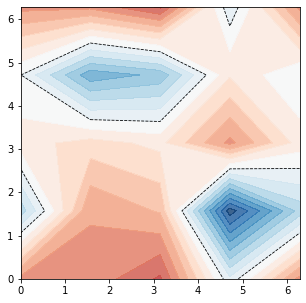

It 531 out of 1550 loss:  0.9455079982873921  : Acc train:  0.64  : Acc test :  0.628  : Auc :  0.634


<Figure size 432x288 with 0 Axes>

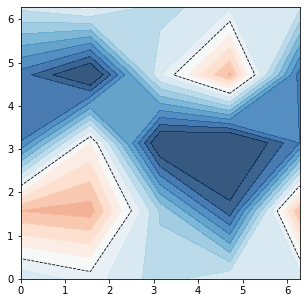

It 541 out of 1550 loss:  0.9638224022305031  : Acc train:  0.69  : Acc test :  0.681  : Auc :  0.674


<Figure size 432x288 with 0 Axes>

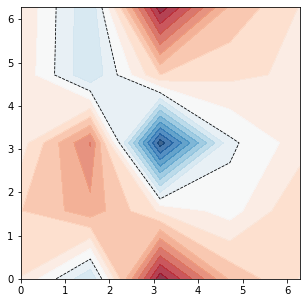

It 551 out of 1550 loss:  0.9764989896852193  : Acc train:  0.63  : Acc test :  0.549  : Auc :  0.558


<Figure size 432x288 with 0 Axes>

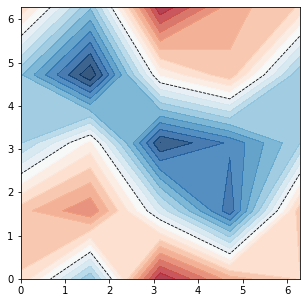

It 561 out of 1550 loss:  0.7501124783221553  : Acc train:  0.7  : Acc test :  0.653  : Auc :  0.653


<Figure size 432x288 with 0 Axes>

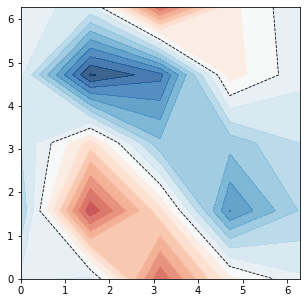

It 571 out of 1550 loss:  1.1885434739018244  : Acc train:  0.71  : Acc test :  0.697  : Auc :  0.693


<Figure size 432x288 with 0 Axes>

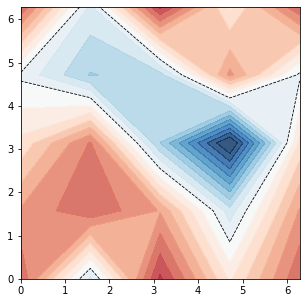

It 581 out of 1550 loss:  0.2216834561765058  : Acc train:  0.7  : Acc test :  0.636  : Auc :  0.643


<Figure size 432x288 with 0 Axes>

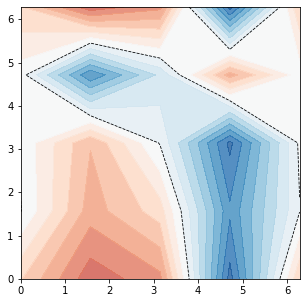

It 591 out of 1550 loss:  1.009020863127096  : Acc train:  0.68  : Acc test :  0.65  : Auc :  0.653


<Figure size 432x288 with 0 Axes>

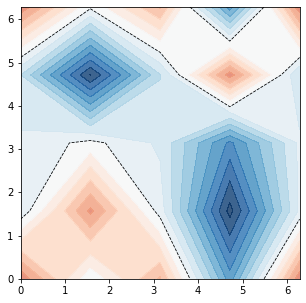

It 601 out of 1550 loss:  0.676691458867915  : Acc train:  0.72  : Acc test :  0.714  : Auc :  0.712


<Figure size 432x288 with 0 Axes>

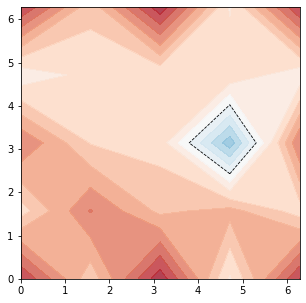

It 611 out of 1550 loss:  1.1969239701410976  : Acc train:  0.6  : Acc test :  0.541  : Auc :  0.557


<Figure size 432x288 with 0 Axes>

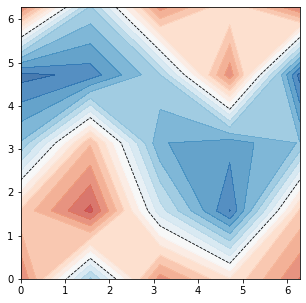

It 621 out of 1550 loss:  0.7453296311221335  : Acc train:  0.73  : Acc test :  0.695  : Auc :  0.694


<Figure size 432x288 with 0 Axes>

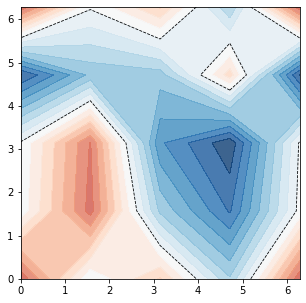

It 631 out of 1550 loss:  0.7029682027139679  : Acc train:  0.76  : Acc test :  0.701  : Auc :  0.699


<Figure size 432x288 with 0 Axes>

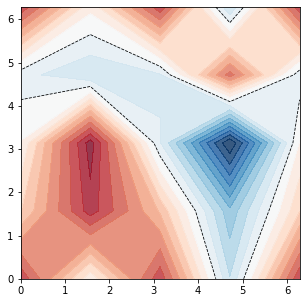

It 641 out of 1550 loss:  0.68230302950878  : Acc train:  0.73  : Acc test :  0.685  : Auc :  0.689


<Figure size 432x288 with 0 Axes>

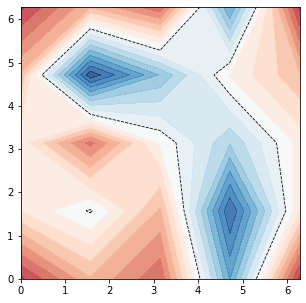

It 651 out of 1550 loss:  0.8902459332754281  : Acc train:  0.69  : Acc test :  0.657  : Auc :  0.663


<Figure size 432x288 with 0 Axes>

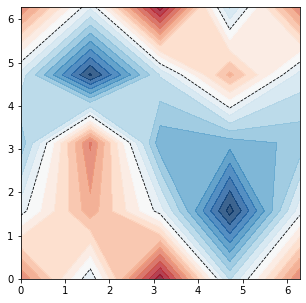

It 661 out of 1550 loss:  0.35478080891097963  : Acc train:  0.73  : Acc test :  0.68  : Auc :  0.68


<Figure size 432x288 with 0 Axes>

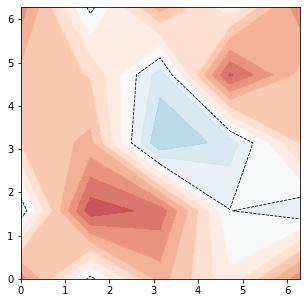

It 671 out of 1550 loss:  0.6792847453753776  : Acc train:  0.62  : Acc test :  0.587  : Auc :  0.599


<Figure size 432x288 with 0 Axes>

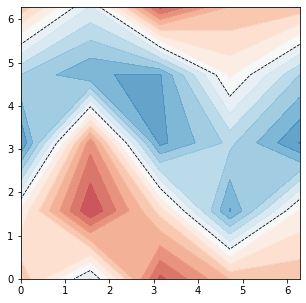

It 681 out of 1550 loss:  0.44780944623796637  : Acc train:  0.72  : Acc test :  0.706  : Auc :  0.704


<Figure size 432x288 with 0 Axes>

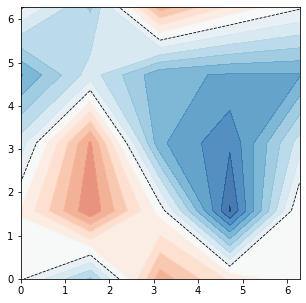

It 691 out of 1550 loss:  0.7256286553400617  : Acc train:  0.76  : Acc test :  0.738  : Auc :  0.734


<Figure size 432x288 with 0 Axes>

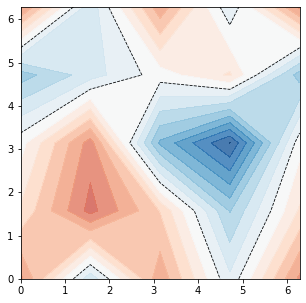

It 701 out of 1550 loss:  0.6042566715073638  : Acc train:  0.73  : Acc test :  0.69  : Auc :  0.692


<Figure size 432x288 with 0 Axes>

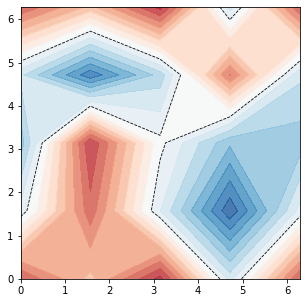

It 711 out of 1550 loss:  0.6165290699731087  : Acc train:  0.72  : Acc test :  0.679  : Auc :  0.681


<Figure size 432x288 with 0 Axes>

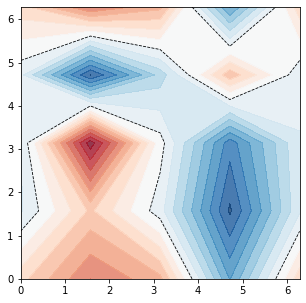

It 721 out of 1550 loss:  0.737561441966365  : Acc train:  0.72  : Acc test :  0.687  : Auc :  0.687


<Figure size 432x288 with 0 Axes>

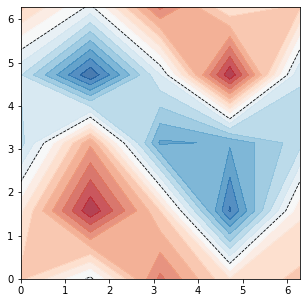

It 731 out of 1550 loss:  0.7832705070695672  : Acc train:  0.71  : Acc test :  0.679  : Auc :  0.681


<Figure size 432x288 with 0 Axes>

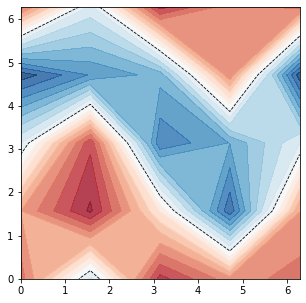

It 741 out of 1550 loss:  0.7816783081842318  : Acc train:  0.73  : Acc test :  0.687  : Auc :  0.688


<Figure size 432x288 with 0 Axes>

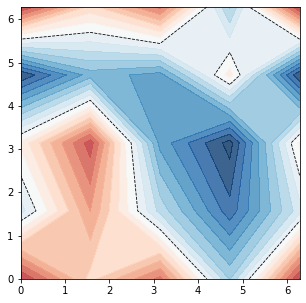

It 751 out of 1550 loss:  0.5880225822412796  : Acc train:  0.74  : Acc test :  0.704  : Auc :  0.703


<Figure size 432x288 with 0 Axes>

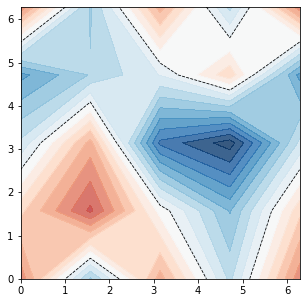

It 761 out of 1550 loss:  1.2571980383371004  : Acc train:  0.74  : Acc test :  0.713  : Auc :  0.712


<Figure size 432x288 with 0 Axes>

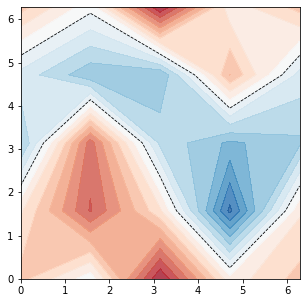

It 771 out of 1550 loss:  0.567312749787053  : Acc train:  0.74  : Acc test :  0.701  : Auc :  0.702


<Figure size 432x288 with 0 Axes>

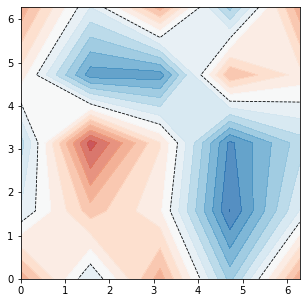

It 781 out of 1550 loss:  0.9763260095039589  : Acc train:  0.7  : Acc test :  0.677  : Auc :  0.68


<Figure size 432x288 with 0 Axes>

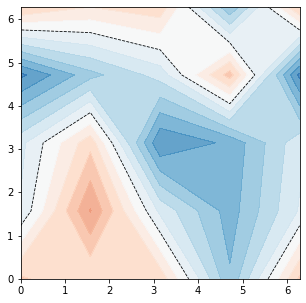

It 791 out of 1550 loss:  0.8243139808665297  : Acc train:  0.74  : Acc test :  0.703  : Auc :  0.7


<Figure size 432x288 with 0 Axes>

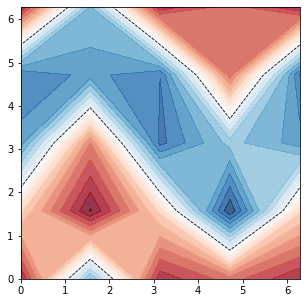

It 801 out of 1550 loss:  0.7389071914941903  : Acc train:  0.71  : Acc test :  0.679  : Auc :  0.678


<Figure size 432x288 with 0 Axes>

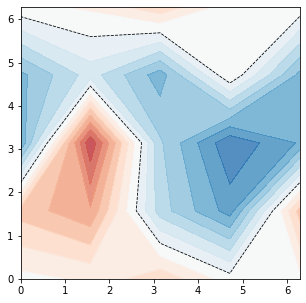

It 811 out of 1550 loss:  0.9750794526340338  : Acc train:  0.7  : Acc test :  0.673  : Auc :  0.669


<Figure size 432x288 with 0 Axes>

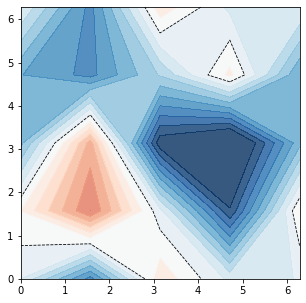

It 821 out of 1550 loss:  0.38789302065262377  : Acc train:  0.72  : Acc test :  0.706  : Auc :  0.7


<Figure size 432x288 with 0 Axes>

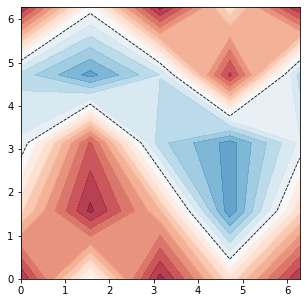

It 831 out of 1550 loss:  0.9311513145963588  : Acc train:  0.72  : Acc test :  0.67  : Auc :  0.674


<Figure size 432x288 with 0 Axes>

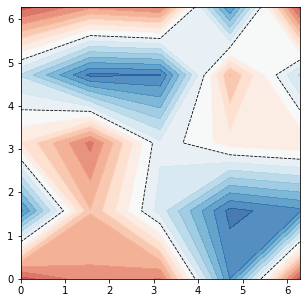

It 841 out of 1550 loss:  1.042990977878909  : Acc train:  0.67  : Acc test :  0.648  : Auc :  0.647


<Figure size 432x288 with 0 Axes>

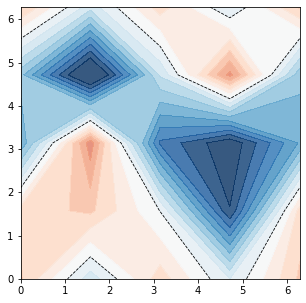

It 851 out of 1550 loss:  0.8488798017452968  : Acc train:  0.72  : Acc test :  0.677  : Auc :  0.675


<Figure size 432x288 with 0 Axes>

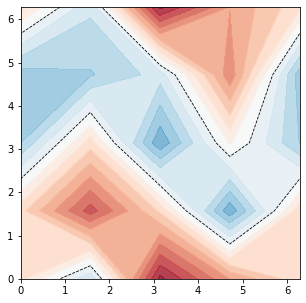

It 861 out of 1550 loss:  0.6624371034046286  : Acc train:  0.69  : Acc test :  0.643  : Auc :  0.645


<Figure size 432x288 with 0 Axes>

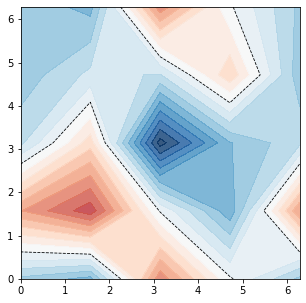

It 871 out of 1550 loss:  0.7763728612100023  : Acc train:  0.7  : Acc test :  0.675  : Auc :  0.672


<Figure size 432x288 with 0 Axes>

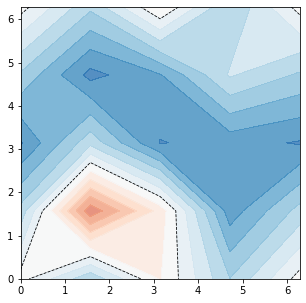

It 881 out of 1550 loss:  1.0350634049216765  : Acc train:  0.68  : Acc test :  0.714  : Auc :  0.704


<Figure size 432x288 with 0 Axes>

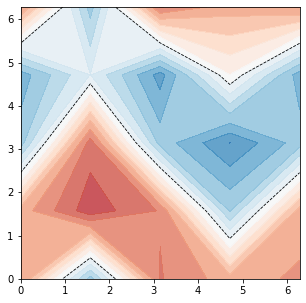

It 891 out of 1550 loss:  0.24156896461770402  : Acc train:  0.73  : Acc test :  0.691  : Auc :  0.692


<Figure size 432x288 with 0 Axes>

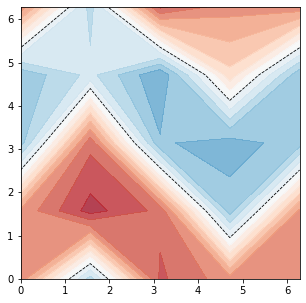

It 901 out of 1550 loss:  0.8604413713869745  : Acc train:  0.72  : Acc test :  0.682  : Auc :  0.684


<Figure size 432x288 with 0 Axes>

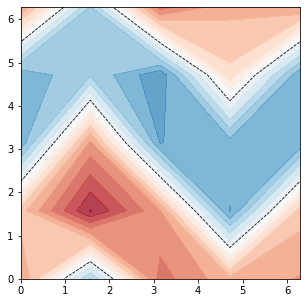

It 911 out of 1550 loss:  0.7899037778328943  : Acc train:  0.72  : Acc test :  0.703  : Auc :  0.702


<Figure size 432x288 with 0 Axes>

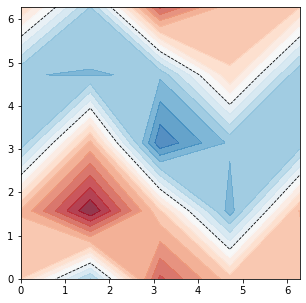

It 921 out of 1550 loss:  0.8818315234520644  : Acc train:  0.73  : Acc test :  0.697  : Auc :  0.696


<Figure size 432x288 with 0 Axes>

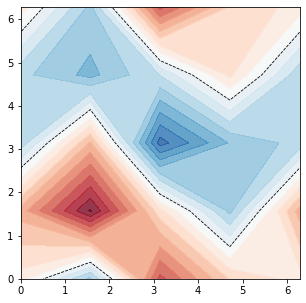

It 931 out of 1550 loss:  0.6830931237573096  : Acc train:  0.74  : Acc test :  0.703  : Auc :  0.703


<Figure size 432x288 with 0 Axes>

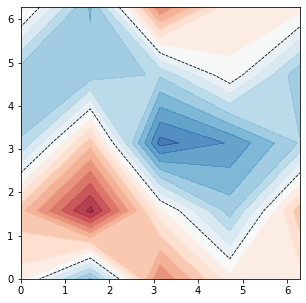

It 941 out of 1550 loss:  0.6707040811593374  : Acc train:  0.74  : Acc test :  0.718  : Auc :  0.716


<Figure size 432x288 with 0 Axes>

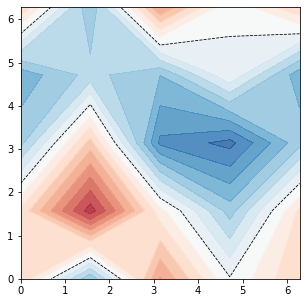

It 951 out of 1550 loss:  0.6652644587574233  : Acc train:  0.75  : Acc test :  0.716  : Auc :  0.713


<Figure size 432x288 with 0 Axes>

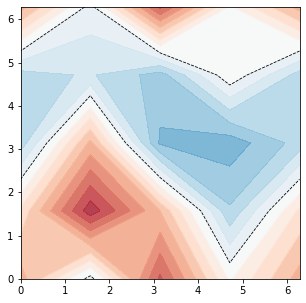

It 961 out of 1550 loss:  1.0216367153573493  : Acc train:  0.75  : Acc test :  0.71  : Auc :  0.71


<Figure size 432x288 with 0 Axes>

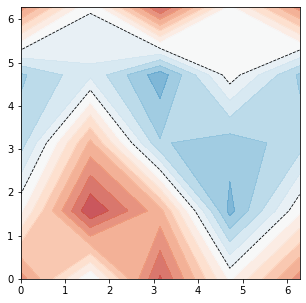

It 971 out of 1550 loss:  0.4650299716636168  : Acc train:  0.74  : Acc test :  0.713  : Auc :  0.713


<Figure size 432x288 with 0 Axes>

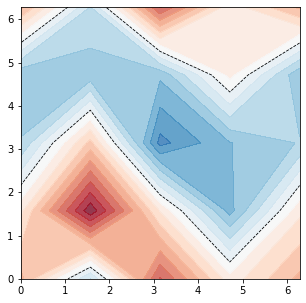

It 981 out of 1550 loss:  0.8316801696523615  : Acc train:  0.75  : Acc test :  0.722  : Auc :  0.72


<Figure size 432x288 with 0 Axes>

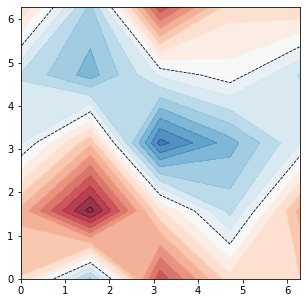

It 991 out of 1550 loss:  0.5248215254374873  : Acc train:  0.75  : Acc test :  0.709  : Auc :  0.709


<Figure size 432x288 with 0 Axes>

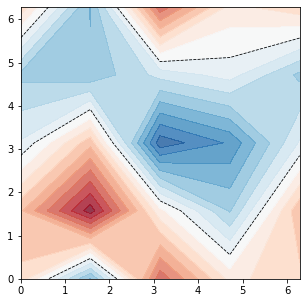

It 1001 out of 1550 loss:  0.5398304783363832  : Acc train:  0.76  : Acc test :  0.719  : Auc :  0.717


<Figure size 432x288 with 0 Axes>

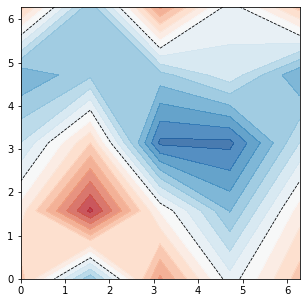

It 1011 out of 1550 loss:  0.6230876736183918  : Acc train:  0.76  : Acc test :  0.729  : Auc :  0.726


<Figure size 432x288 with 0 Axes>

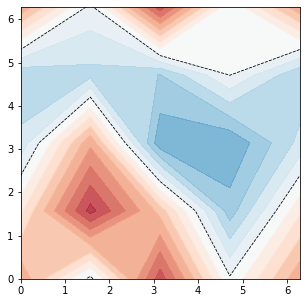

It 1021 out of 1550 loss:  0.5592099168949223  : Acc train:  0.76  : Acc test :  0.718  : Auc :  0.717


<Figure size 432x288 with 0 Axes>

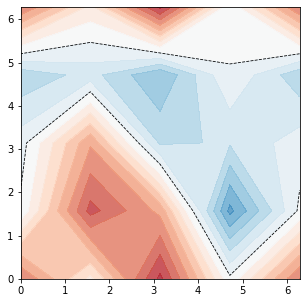

It 1031 out of 1550 loss:  0.760218749132165  : Acc train:  0.73  : Acc test :  0.71  : Auc :  0.71


<Figure size 432x288 with 0 Axes>

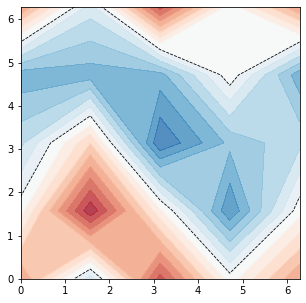

It 1041 out of 1550 loss:  0.8290019480812745  : Acc train:  0.75  : Acc test :  0.731  : Auc :  0.728


<Figure size 432x288 with 0 Axes>

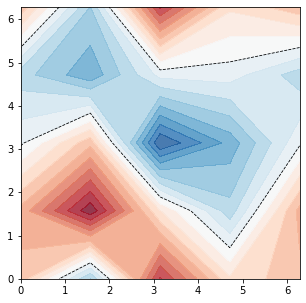

It 1051 out of 1550 loss:  0.5825797248652372  : Acc train:  0.76  : Acc test :  0.711  : Auc :  0.71


<Figure size 432x288 with 0 Axes>

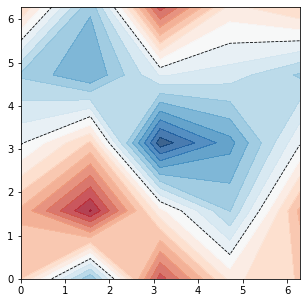

It 1061 out of 1550 loss:  0.5749801318986119  : Acc train:  0.76  : Acc test :  0.719  : Auc :  0.718


<Figure size 432x288 with 0 Axes>

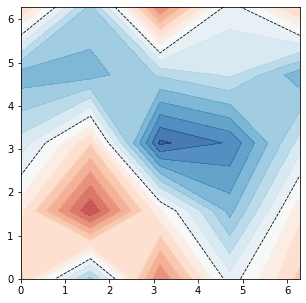

It 1071 out of 1550 loss:  1.1518155007158506  : Acc train:  0.76  : Acc test :  0.741  : Auc :  0.737


<Figure size 432x288 with 0 Axes>

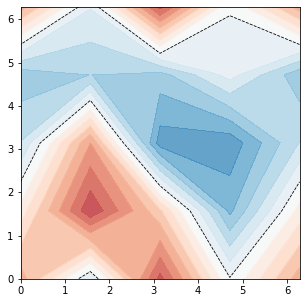

It 1081 out of 1550 loss:  0.6520802931230276  : Acc train:  0.76  : Acc test :  0.722  : Auc :  0.721


<Figure size 432x288 with 0 Axes>

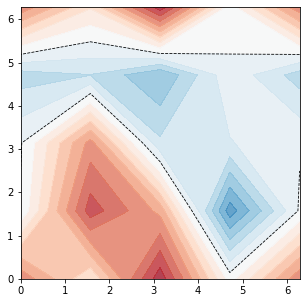

It 1091 out of 1550 loss:  0.9294099411049773  : Acc train:  0.74  : Acc test :  0.717  : Auc :  0.718


<Figure size 432x288 with 0 Axes>

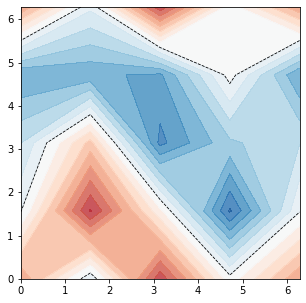

It 1101 out of 1550 loss:  0.7291852921643298  : Acc train:  0.75  : Acc test :  0.73  : Auc :  0.727


<Figure size 432x288 with 0 Axes>

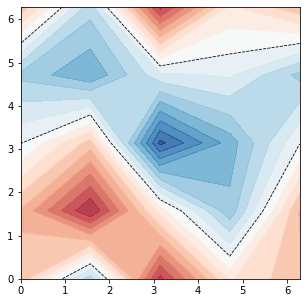

It 1111 out of 1550 loss:  0.5821277205033308  : Acc train:  0.76  : Acc test :  0.72  : Auc :  0.719


<Figure size 432x288 with 0 Axes>

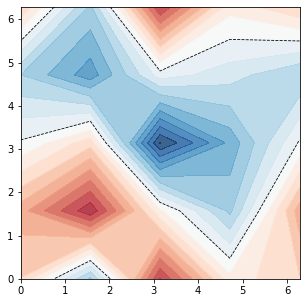

It 1121 out of 1550 loss:  1.3640728089757224  : Acc train:  0.76  : Acc test :  0.717  : Auc :  0.716


<Figure size 432x288 with 0 Axes>

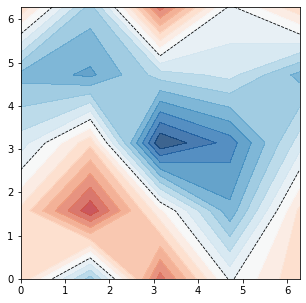

It 1131 out of 1550 loss:  0.5582722332929306  : Acc train:  0.76  : Acc test :  0.739  : Auc :  0.736


<Figure size 432x288 with 0 Axes>

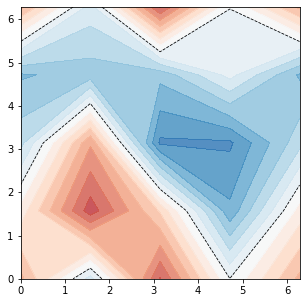

It 1141 out of 1550 loss:  0.7930936297245903  : Acc train:  0.76  : Acc test :  0.723  : Auc :  0.722


<Figure size 432x288 with 0 Axes>

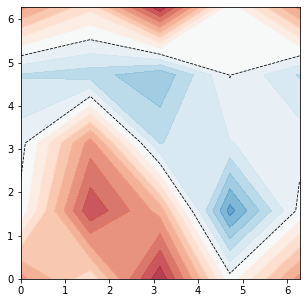

It 1151 out of 1550 loss:  0.8367156099393249  : Acc train:  0.75  : Acc test :  0.721  : Auc :  0.722


<Figure size 432x288 with 0 Axes>

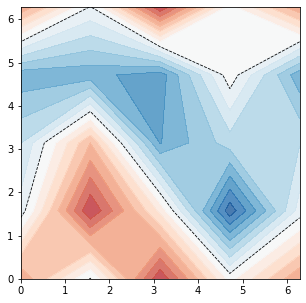

It 1161 out of 1550 loss:  0.5754233849199462  : Acc train:  0.75  : Acc test :  0.73  : Auc :  0.728


<Figure size 432x288 with 0 Axes>

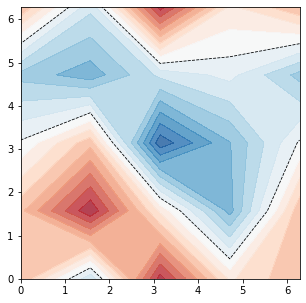

It 1171 out of 1550 loss:  0.41962785467851216  : Acc train:  0.76  : Acc test :  0.723  : Auc :  0.723


<Figure size 432x288 with 0 Axes>

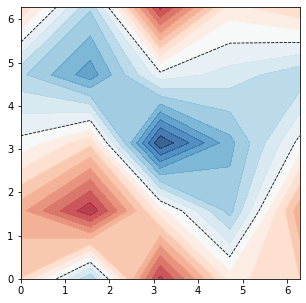

It 1181 out of 1550 loss:  0.6338587196448912  : Acc train:  0.76  : Acc test :  0.711  : Auc :  0.71


<Figure size 432x288 with 0 Axes>

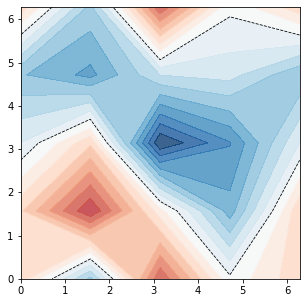

It 1191 out of 1550 loss:  0.7404923346172211  : Acc train:  0.77  : Acc test :  0.733  : Auc :  0.731


<Figure size 432x288 with 0 Axes>

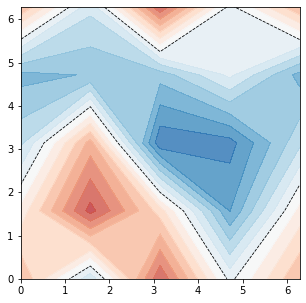

It 1201 out of 1550 loss:  0.2921536075213553  : Acc train:  0.76  : Acc test :  0.728  : Auc :  0.726


<Figure size 432x288 with 0 Axes>

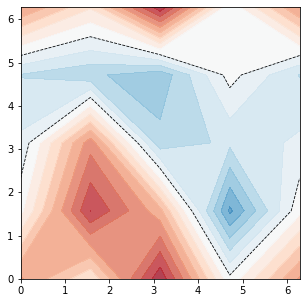

It 1211 out of 1550 loss:  0.9043210201775836  : Acc train:  0.75  : Acc test :  0.723  : Auc :  0.724


<Figure size 432x288 with 0 Axes>

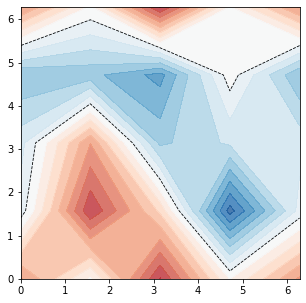

It 1221 out of 1550 loss:  0.6911248702916382  : Acc train:  0.75  : Acc test :  0.72  : Auc :  0.719


<Figure size 432x288 with 0 Axes>

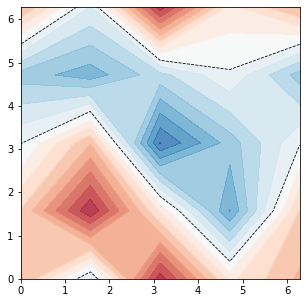

It 1231 out of 1550 loss:  0.8029133800685326  : Acc train:  0.77  : Acc test :  0.723  : Auc :  0.723


<Figure size 432x288 with 0 Axes>

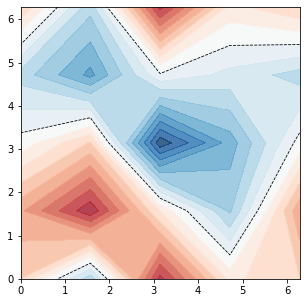

It 1241 out of 1550 loss:  0.6164943963491352  : Acc train:  0.76  : Acc test :  0.71  : Auc :  0.71


<Figure size 432x288 with 0 Axes>

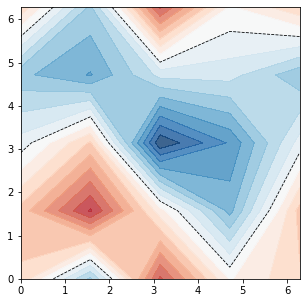

It 1251 out of 1550 loss:  0.6032958286781145  : Acc train:  0.76  : Acc test :  0.728  : Auc :  0.726


<Figure size 432x288 with 0 Axes>

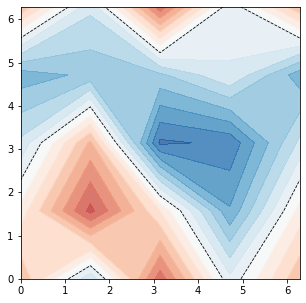

It 1261 out of 1550 loss:  0.7226621827254835  : Acc train:  0.77  : Acc test :  0.734  : Auc :  0.732


<Figure size 432x288 with 0 Axes>

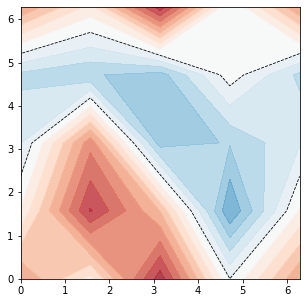

It 1271 out of 1550 loss:  1.0248100460878438  : Acc train:  0.76  : Acc test :  0.723  : Auc :  0.723


<Figure size 432x288 with 0 Axes>

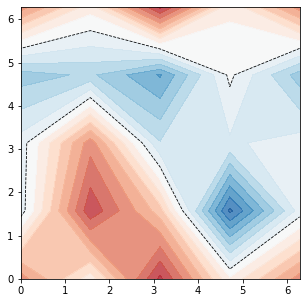

It 1281 out of 1550 loss:  0.40906858613879143  : Acc train:  0.75  : Acc test :  0.725  : Auc :  0.724


<Figure size 432x288 with 0 Axes>

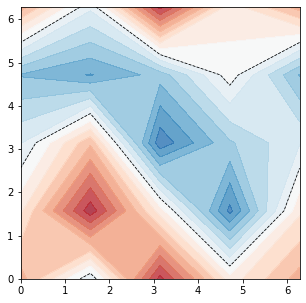

It 1291 out of 1550 loss:  0.8813568455742602  : Acc train:  0.77  : Acc test :  0.733  : Auc :  0.731


<Figure size 432x288 with 0 Axes>

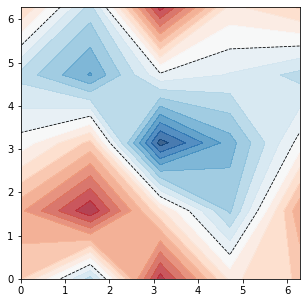

It 1301 out of 1550 loss:  0.4805029891665102  : Acc train:  0.76  : Acc test :  0.711  : Auc :  0.711


<Figure size 432x288 with 0 Axes>

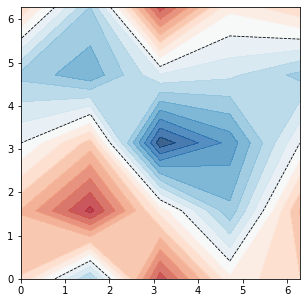

It 1311 out of 1550 loss:  0.5172643741721462  : Acc train:  0.76  : Acc test :  0.723  : Auc :  0.722


<Figure size 432x288 with 0 Axes>

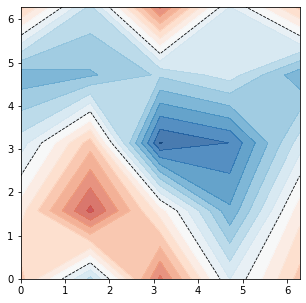

It 1321 out of 1550 loss:  0.6298405075095812  : Acc train:  0.76  : Acc test :  0.737  : Auc :  0.734


<Figure size 432x288 with 0 Axes>

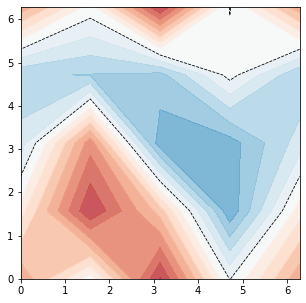

It 1331 out of 1550 loss:  0.5607149694668329  : Acc train:  0.76  : Acc test :  0.721  : Auc :  0.721


<Figure size 432x288 with 0 Axes>

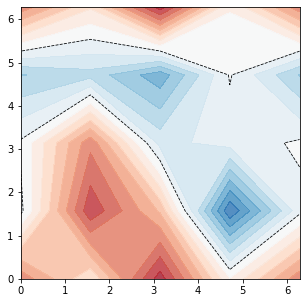

It 1341 out of 1550 loss:  0.6933635950444295  : Acc train:  0.75  : Acc test :  0.718  : Auc :  0.719


<Figure size 432x288 with 0 Axes>

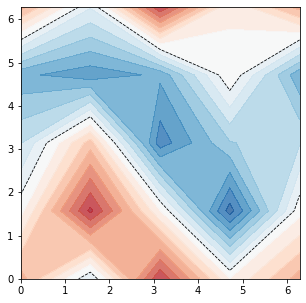

It 1351 out of 1550 loss:  0.8432642840803071  : Acc train:  0.76  : Acc test :  0.736  : Auc :  0.733


<Figure size 432x288 with 0 Axes>

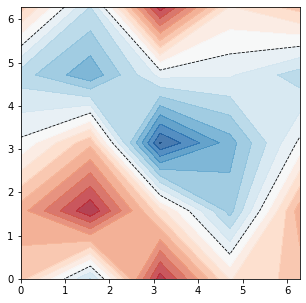

It 1361 out of 1550 loss:  0.5679967984908587  : Acc train:  0.76  : Acc test :  0.713  : Auc :  0.713


<Figure size 432x288 with 0 Axes>

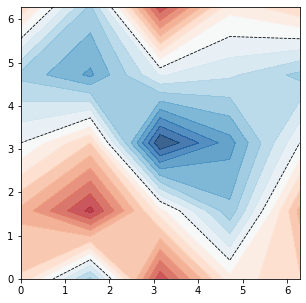

It 1371 out of 1550 loss:  0.5761569401382731  : Acc train:  0.76  : Acc test :  0.72  : Auc :  0.719


<Figure size 432x288 with 0 Axes>

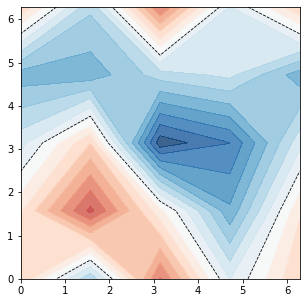

It 1381 out of 1550 loss:  1.1503632737727922  : Acc train:  0.76  : Acc test :  0.741  : Auc :  0.737


<Figure size 432x288 with 0 Axes>

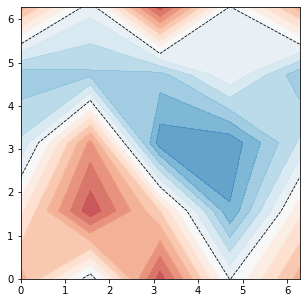

It 1391 out of 1550 loss:  0.6428595825974377  : Acc train:  0.76  : Acc test :  0.719  : Auc :  0.718


<Figure size 432x288 with 0 Axes>

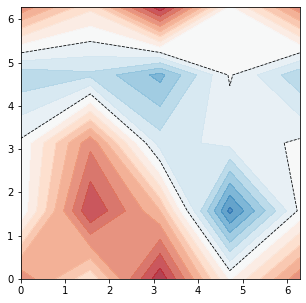

It 1401 out of 1550 loss:  0.940498397783241  : Acc train:  0.75  : Acc test :  0.718  : Auc :  0.719


<Figure size 432x288 with 0 Axes>

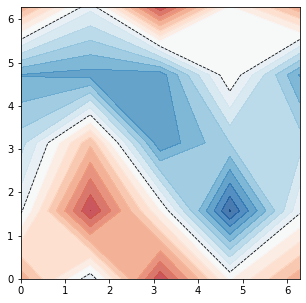

It 1411 out of 1550 loss:  0.7599583703392175  : Acc train:  0.75  : Acc test :  0.732  : Auc :  0.729


<Figure size 432x288 with 0 Axes>

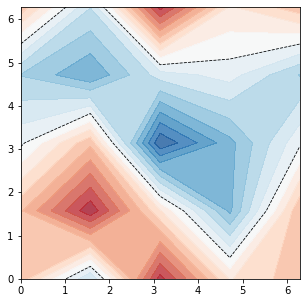

It 1421 out of 1550 loss:  0.5898416259511092  : Acc train:  0.76  : Acc test :  0.72  : Auc :  0.719


<Figure size 432x288 with 0 Axes>

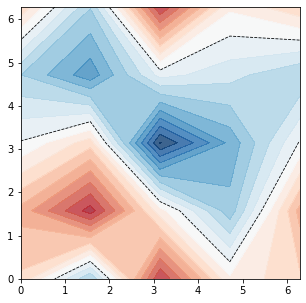

It 1431 out of 1550 loss:  1.3480051035899683  : Acc train:  0.76  : Acc test :  0.72  : Auc :  0.719


<Figure size 432x288 with 0 Axes>

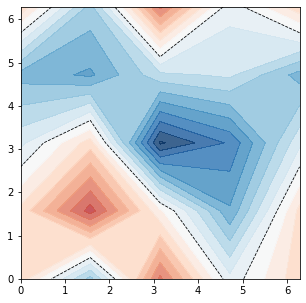

It 1441 out of 1550 loss:  0.5377512036685891  : Acc train:  0.76  : Acc test :  0.74  : Auc :  0.736


<Figure size 432x288 with 0 Axes>

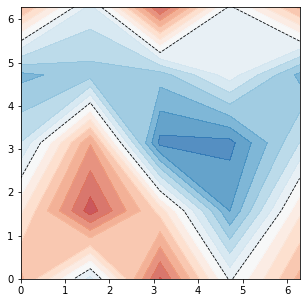

It 1451 out of 1550 loss:  0.7772422522453326  : Acc train:  0.76  : Acc test :  0.725  : Auc :  0.723


<Figure size 432x288 with 0 Axes>

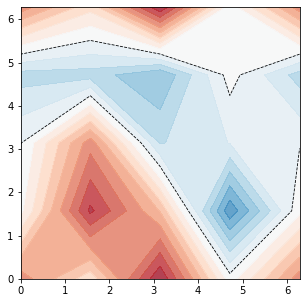

It 1461 out of 1550 loss:  0.826767841620349  : Acc train:  0.76  : Acc test :  0.721  : Auc :  0.722


<Figure size 432x288 with 0 Axes>

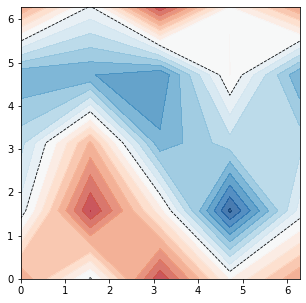

It 1471 out of 1550 loss:  0.5776825760953561  : Acc train:  0.75  : Acc test :  0.728  : Auc :  0.726


<Figure size 432x288 with 0 Axes>

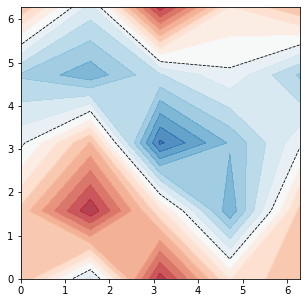

It 1481 out of 1550 loss:  0.41409277328354954  : Acc train:  0.76  : Acc test :  0.721  : Auc :  0.72


<Figure size 432x288 with 0 Axes>

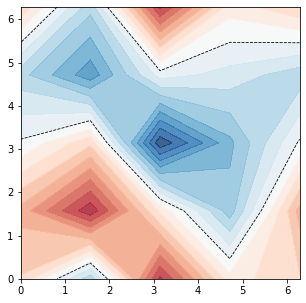

It 1491 out of 1550 loss:  0.6375386608888216  : Acc train:  0.76  : Acc test :  0.719  : Auc :  0.718


<Figure size 432x288 with 0 Axes>

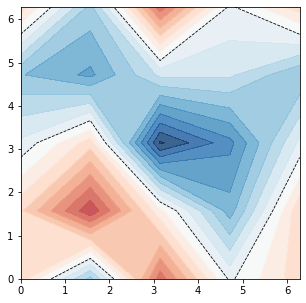

It 1501 out of 1550 loss:  0.729428470704859  : Acc train:  0.77  : Acc test :  0.735  : Auc :  0.733


<Figure size 432x288 with 0 Axes>

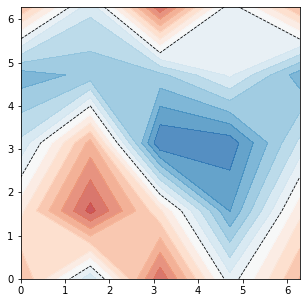

It 1511 out of 1550 loss:  0.2901300879703037  : Acc train:  0.77  : Acc test :  0.733  : Auc :  0.73


<Figure size 432x288 with 0 Axes>

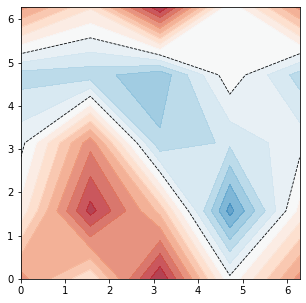

It 1521 out of 1550 loss:  0.9102227282308862  : Acc train:  0.76  : Acc test :  0.721  : Auc :  0.721


<Figure size 432x288 with 0 Axes>

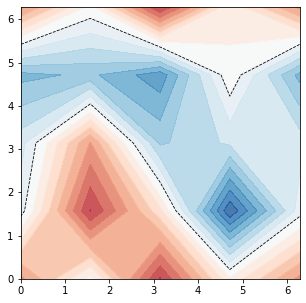

It 1531 out of 1550 loss:  0.6700302838228414  : Acc train:  0.75  : Acc test :  0.719  : Auc :  0.718


<Figure size 432x288 with 0 Axes>

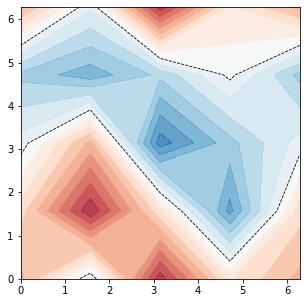

It 1541 out of 1550 loss:  0.8242216780441355  : Acc train:  0.76  : Acc test :  0.729  : Auc :  0.729


In [4]:
from sklearn.metrics import roc_auc_score
# select number of qubits
#n_qubits = X.shape[1] # number of qubits is equal to the number of features = 2


# quantum device handle
dev = qml.device("default.qubit", wires=n_qubits)
# quantum circuit
#
#

@qml.qnode(dev)
def circuit(weights, x=None):
    for i in range(blocks):
        AngleEmbedding(x, wires = range(n_qubits))
        StronglyEntanglingLayers(weights[i], wires = range(n_qubits),imprimitive=entangler)
    return qml.expval(qml.PauliZ(0))

# variational quantum classifier
def variational_classifier(theta, x=None):
    weights = theta[0]
    bias = theta[1]
    return circuit(weights, x=x) + bias

# draw random quantum node weights
theta_weights = [strong_ent_layers_uniform(layers, n_qubits, seed=randomseed+i+1) for i in range(blocks)]
theta_bias = 0.0
theta_init = (theta_weights, theta_bias) # initial weights

def cost(theta, X, expectations):
    e_predicted = \
        np.array([variational_classifier(theta, x=x) for x in X])
    loss = np.mean((e_predicted - expectations)**2)    
    return loss


def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


# convert classes to expectations: -1 to -1, 1 to +1
e_train = np.empty_like(y_train)
e_train[y_train == -1] = -1
e_train[y_train == 1] = +1
# calculate numbe of batches
batches = len(X_train) // batch_size

# train the variational classifier
theta = theta_init


# split training data into batches
X_batches = np.array_split(np.arange(len(X_train)), batches)


lossplot = []
aucrocplot = []
accuracytrainplot = []
accuracytestplot = []
for it, batch_index in enumerate(chain(*(n_epochs * [X_batches]))):

    
    if it <= 880:
        
    # Update the weights by one optimizer step
        batch_cost = \
        lambda theta: cost(theta, X_train[batch_index], e_train[batch_index])
        theta = opt.step(batch_cost, theta)
    elif it >= 880:
        
    # Update the weights by one optimizer step
        batch_cost = \
        lambda theta: cost(theta, X_train[batch_index], e_train[batch_index])
        theta = opt1.step(batch_cost, theta)
    
    
    # use X_validation and y_validation to decide whether to stop
    # end of learning loop
    
    if it % 10 == 0:
        expectations = np.array([variational_classifier(theta, x=x) for x in X_train])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_onet = prob_class_one.to_numpy()
           
        expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_one = prob_class_one.to_numpy()
        #
        #
        #--------- GRID PLOT START
        #
        #
        plt.figure()
        cm = plt.cm.RdBu
        fig= plt.figure(figsize=(5,5))
        xx, yy = np.meshgrid(np.linspace(scalinga, scalingb, 5), np.linspace(scalinga,scalingb, 5))
        X_grid = [np.array([x,y]) for x, y in zip(xx.flatten(), yy.flatten())]
        predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
        zminus = (predictions_grid + 1.0) / 2.0
        zminus = predictions_grid
        Z=np.reshape(zminus, xx.shape)
# plot decision regions
        cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1., 0.1), cmap=cm, alpha=0.8, extend="both")
        plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
        plt.show()
        #
        #
        #--------- GRID PLOT END
        #
        #
    #print("Acc test",metrics.accuracy_score(y_test, prob_class_one))
    #print(metrics.confusion_matrix(y_test, prob_class_one))
        lossplot.append(cost(theta, X_train[batch_index], e_train[batch_index]))
        aucrocplot.append(roc_auc_score(y_test, prob_class_one))
        accuracytrainplot.append(metrics.accuracy_score(y_train, prob_class_onet))
        accuracytestplot.append(metrics.accuracy_score(y_test, prob_class_one))
#    print("It",it+1,"out of",len(X_batches) *n_epochs)
        print("It",it+1,"out of",len(X_batches) *n_epochs, "loss: ",cost(theta, X_train[batch_index], e_train[batch_index]),
        " : Acc train: ",round(metrics.accuracy_score(y_train, prob_class_onet),2),
        " : Acc test : ",round(metrics.accuracy_score(y_test, prob_class_one),3),
        " : Auc : ",round(roc_auc_score(y_test, prob_class_one),3)
        )
        if metrics.accuracy_score(y_train, prob_class_onet) >= 0.97:
                break
             

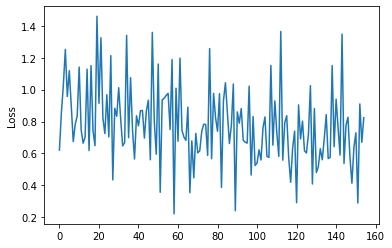

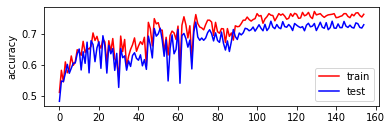

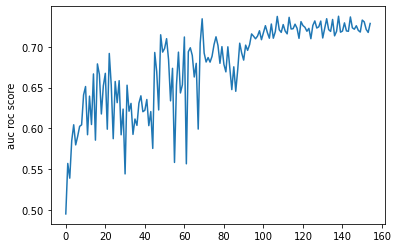

In [5]:
plt.plot(lossplot) #lets plot the second line
plt.ylabel('Loss')
plt.show()

plt.subplot(2,1,1)
plt.plot(accuracytrainplot,'r',label="train")
plt.plot(accuracytestplot,'b',label="test")
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(aucrocplot) #lets plot the second line
plt.ylabel('auc roc score')
plt.show()

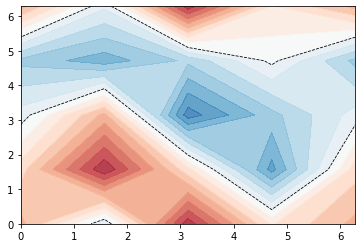

In [6]:
predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
predictions_grid = (predictions_grid + 1.0) / 2.0
predictions_grid = pd.DataFrame.from_dict(predictions_grid)
predictions_grid = predictions_grid.iloc[:, :]
predictions_grid = predictions_grid[0].apply(lambda x: 0 if x <= 0.5 else 1)
predictions_grid = predictions_grid.to_numpy()
Z=predictions_grid
Z=np.reshape(zminus, xx.shape)
Z
cnt = plt.contourf(xx, yy,Z, levels=np.arange(-1, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))

#plt.colorbar(cnt, ticks=[-1, 0, 1])

In [7]:
# METRICS FOR TESTING DATA
expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
prob_class_one = pd.DataFrame.from_dict(prob_class_one)
prob_class_one = prob_class_one.iloc[:, :]
prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
prob_class_one = prob_class_one.to_numpy()
print(metrics.accuracy_score(y_test, prob_class_one))
print(metrics.confusion_matrix(y_test, prob_class_one))

0.7166666666666667
[[509 208]
 [217 566]]


<Figure size 1440x1440 with 0 Axes>

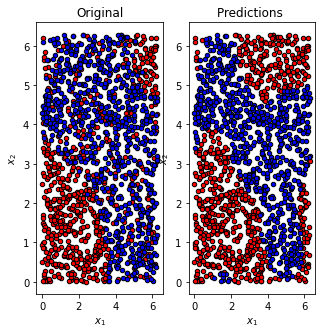

In [8]:
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
y_pred = (prob_class_one >= 0.5)


y_test1 = pd.DataFrame.from_dict(y_test)
y_test1 = y_test1.iloc[:, :]
y_test1 =  y_test1[0].apply(lambda x: 0 if x <= 0 else 1)
y_test1 = y_test1.to_numpy()

fig= plt.figure(figsize=(20,20))
fig , axes = plt.subplots(1, 2, figsize=(5, 5))
plot_data(X_test, y_test1, fig, axes[0])
plot_data(X_test, y_pred, fig, axes[1])
#plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Original")
axes[1].set_title("Predictions ")
plt.show()

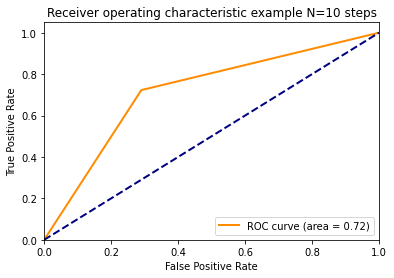

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()

expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
y_pred = (prob_class_one >= 0.5)

y_test=y_test
y_score=y_pred

for i in range(len(y_test)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example Ν=10 steps')
plt.legend(loc="lower right")
plt.show()

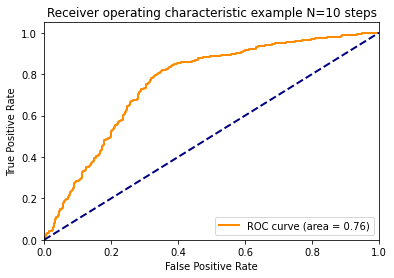

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()

expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
y_pred = prob_class_one

y_test=y_test
y_score=y_pred

for i in range(len(y_test)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example Ν=10 steps')
plt.legend(loc="lower right")
plt.show()

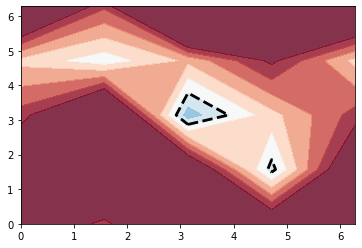

In [11]:
predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
predictions_grid = (predictions_grid + 1.0) / 2.0
predictions_grid = pd.DataFrame.from_dict(predictions_grid)
predictions_grid = predictions_grid.iloc[:, :]
predictions_grid = predictions_grid[0].apply(lambda x: 0 if x <= 0.5 else 1)
predictions_grid = predictions_grid.to_numpy()
Z=predictions_grid
Z=np.reshape(zminus, xx.shape)
Z


cnt = plt.contourf(xx, yy,Z, levels=np.arange(0, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(2.8,))

#plt.colorbar(cnt, ticks=[-1, 0, 1])

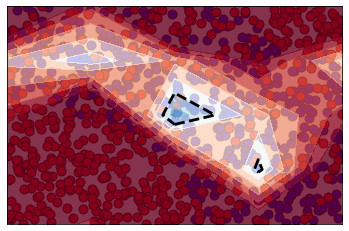

In [12]:
predictions_grid = np.array([variational_classifier(theta, x=x) for x in X_grid])
predictions_grid = (predictions_grid + 1.0) / 2.0
predictions_grid = pd.DataFrame.from_dict(predictions_grid)
predictions_grid = predictions_grid.iloc[:, :]
predictions_grid = predictions_grid[0].apply(lambda x: 0 if x <= 0.5 else 1)
predictions_grid = predictions_grid.to_numpy()
Z=predictions_grid
Z=np.reshape(zminus, xx.shape)
Z

# plot data
plt.scatter(
    X_train[:, 0][e_train == 1],
    X_train[:, 1][e_train == 1],
    c="b",
    marker="o",s=80,
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_train[:, 0][e_train == -1],
    X_train[:, 1][e_train == -1],
    c="r",
    marker="o",s=80,
    edgecolors="k",
    label="class -1 train",
)
cnt = plt.contourf(xx, yy,Z, levels=np.arange(0, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,Z, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(2.8,))
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
#plt.colorbar(cnt, ticks=[-1, 0, 1])

In [13]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
prob_class_one = (expectations + 1) / 2.0
prob_class_one = pd.DataFrame.from_dict(prob_class_one)
prob_class_one = prob_class_one.iloc[:, :]
prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
prob_class_one = prob_class_one.to_numpy()

predictions = [np.sign(variational_classifier(theta, x)) for x in X_test]
acc_test = accuracy(y_test, prob_class_one)
acc_test

0.7166666666666667